This notebook contains different models that attempt to classify hate speech from Twitter. It was built as part of this research: https://arxiv.org/pdf/1703.04009.pdf 

In [1]:
import pandas as pd
import numpy as np
import sys
from sklearn.feature_extraction.text import TfidfVectorizer
import nltk
from nltk.stem.porter import *
import string
import re
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer as VS
from textstat.textstat import *
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import classification_report
from sklearn.svm import LinearSVC
import matplotlib.pyplot as plt
import seaborn
%matplotlib inline

In [ ]:
#nltk.download('averaged_perceptron_tagger')

In [2]:
df = pd.read_csv('../data/twitter-hate-speech2.csv', encoding='latin-1')

In [3]:
df.head()

,Unnamed: 0,count,hate_speech,offensive_language,neither,class,tweet
0,0,3,0,0,3,2,!!! RT @mayasolovely: As a woman you shouldn't...
1,1,3,0,3,0,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...
2,2,3,0,3,0,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...
3,3,3,0,2,1,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...
4,4,6,0,6,0,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...


In [4]:
df.describe()

,Unnamed: 0,count,hate_speech,offensive_language,neither,class
count,24783.000000,24783.000000,24783.000000,24783.000000,24783.000000,24783.000000
mean,12681.192027,3.243473,0.280515,2.413711,0.549247,1.110277
std,7299.553863,0.883060,0.631851,1.399459,1.113299,0.462089
min,0.000000,3.000000,0.000000,0.000000,0.000000,0.000000
25%,6372.500000,3.000000,0.000000,2.000000,0.000000,1.000000
50%,12703.000000,3.000000,0.000000,3.000000,0.000000,1.000000
75%,18995.500000,3.000000,0.000000,3.000000,0.000000,1.000000
max,25296.000000,9.000000,7.000000,9.000000,9.000000,2.000000


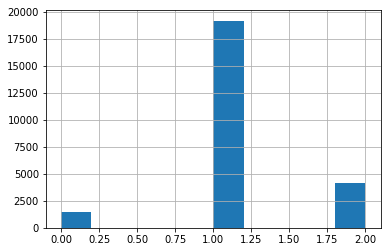

In [5]:
df['class'].hist()

In [6]:
from sklearn.model_selection import cross_val_score, StratifiedShuffleSplit
X=df['tweet']
y=df['class']

sss = StratifiedShuffleSplit(n_splits=1, test_size=.15, random_state=0) #TODO: Coordinate random seed between notebooks
train_index, test_index = next(sss.split(X,y))

X_train = X.iloc[train_index]
X_test = X.iloc[test_index]
y_train = y.iloc[train_index]
y_test = y.iloc[test_index]

# Feature Engineering

In [8]:
stopwords=stopwords = nltk.corpus.stopwords.words("english")

other_exclusions = ["#ff", "ff", "rt"]
stopwords.extend(other_exclusions)

stemmer = PorterStemmer()

def preprocess(text_string):
    """
    Accepts a text string and replaces:
    1) urls with URLHERE
    2) lots of whitespace with one instance
    3) mentions with MENTIONHERE

    This allows us to get standardized counts of urls and mentions
    Without caring about specific people mentioned
    """
    space_pattern = '\s+'
    giant_url_regex = ('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|'
        '[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+')
    mention_regex = '@[\w\-]+'
    parsed_text = re.sub(space_pattern, ' ', text_string)
    parsed_text = re.sub(giant_url_regex, '', parsed_text)
    parsed_text = re.sub(mention_regex, '', parsed_text)
    return parsed_text

def tokenize(tweet):
    """Removes punctuation & excess whitespace, sets to lowercase,
    and stems tweets. Returns a list of stemmed tokens."""
    tweet = " ".join(re.split("[^a-zA-Z]*", tweet.lower())).strip()
    tokens = [stemmer.stem(t) for t in tweet.split()]
    return tokens

def basic_tokenize(tweet):
    """Same as tokenize but without the stemming"""
    tweet = " ".join(re.split("[^a-zA-Z.,!?]*", tweet.lower())).strip()
    return tweet.split()

In [10]:
from sklearn.base import BaseEstimator, TransformerMixin
class PosTfidfVectorizer(BaseEstimator, TransformerMixin):
    """Get POS tags for tweets and transform via tfidf"""
    
    def __init__(self):
        self._pos_vectorizer = TfidfVectorizer(
            tokenizer=None,
            lowercase=False,
            preprocessor=None,
            ngram_range=(1, 3),
            stop_words=None,
            use_idf=False,
            smooth_idf=False,
            norm=None,
            decode_error='replace',
            max_features=5000,
            min_df=5,
            max_df=0.75,
            )    
    
    def _preprocess(self, X):
        tweet_tags = []
        for t in X:
            tokens = basic_tokenize(preprocess(t))
            tags = nltk.pos_tag(tokens)
            tag_list = [x[1] for x in tags]
            tag_str = " ".join(tag_list)
            tweet_tags.append(tag_str)
        return tweet_tags
    
    def fit(self, X, y=None):
        tweet_tags = self._preprocess(X)
        self._pos_vectorizer.fit(X)
        
        return self
    
    def transform(self, X, y=None):
        tweet_tags = self._preprocess(X)
        return self._pos_vectorizer.transform(X)

In [38]:
sentiment_analyzer = VS()

def count_twitter_objs(text_string):
    """
    Accepts a text string and replaces:
    1) urls with URLHERE
    2) lots of whitespace with one instance
    3) mentions with MENTIONHERE
    4) hashtags with HASHTAGHERE

    This allows us to get standardized counts of urls and mentions
    Without caring about specific people mentioned.
    
    Returns counts of urls, mentions, and hashtags.
    """
    space_pattern = '\s+'
    giant_url_regex = ('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|'
        '[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+')
    mention_regex = '@[\w\-]+'
    hashtag_regex = '#[\w\-]+'
    parsed_text = re.sub(space_pattern, ' ', text_string)
    parsed_text = re.sub(giant_url_regex, 'URLHERE', parsed_text)
    parsed_text = re.sub(mention_regex, 'MENTIONHERE', parsed_text)
    parsed_text = re.sub(hashtag_regex, 'HASHTAGHERE', parsed_text)
    return(parsed_text.count('URLHERE'),parsed_text.count('MENTIONHERE'),parsed_text.count('HASHTAGHERE'))

def other_features(tweet):
    """This function takes a string and returns a list of features.
    These include Sentiment scores, Text and Readability scores,
    as well as Twitter specific features"""
    sentiment = sentiment_analyzer.polarity_scores(tweet)
    
    words = preprocess(tweet) #Get text only
    
    syllables = textstat.syllable_count(words)
    num_chars = sum(len(w) for w in words)
    num_chars_total = len(tweet)
    num_terms = len(tweet.split())
    num_words = len(words.split())
    avg_syl = round(float((syllables+0.001))/float(num_words+0.001),4)
    num_unique_terms = len(set(words.split()))
    
    ###Modified FK grade, where avg words per sentence is just num words/1
    FKRA = round(float(0.39 * float(num_words)/1.0) + float(11.8 * avg_syl) - 15.59,1)
    ##Modified FRE score, where sentence fixed to 1
    FRE = round(206.835 - 1.015*(float(num_words)/1.0) - (84.6*float(avg_syl)),2)
    
    twitter_objs = count_twitter_objs(tweet)
    retweet = 0
    if "rt" in words:
        retweet = 1
    features = [FKRA, FRE,syllables, avg_syl, num_chars, num_chars_total, num_terms, num_words,
                num_unique_terms, sentiment['neg'], sentiment['pos'], sentiment['neu'], sentiment['compound'],
                twitter_objs[2], twitter_objs[1],
                twitter_objs[0], retweet]
    return features

def get_feature_array(tweets):
    feats=[]
    for t in tweets:
        feats.append(other_features(t))
    return np.array(feats)

class SentimentVectorizer(BaseEstimator, TransformerMixin): 

    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        return get_feature_array(X)

In [44]:
from sklearn.pipeline import FeatureUnion, Pipeline

vectorizer = TfidfVectorizer(
    tokenizer=tokenize,
    preprocessor=preprocess,
    ngram_range=(1, 3),
    stop_words=stopwords,
    use_idf=True,
    smooth_idf=False,
    norm=None,
    decode_error='replace',
    max_features=10000,
    min_df=5,
    max_df=0.75
    )
pos_vectorizer = PosTfidfVectorizer()
sentiment_vectorizer = SentimentVectorizer()

model = Pipeline( [('features', FeatureUnion([('tfidf', vectorizer),('pos_tfidf', pos_vectorizer), 
                                             ('sentiment',sentiment_vectorizer)])),
                  ('feature_selector', SelectFromModel(LogisticRegression(class_weight='balanced',penalty="l1",C=0.01))),
                  ('model', LogisticRegression(class_weight='balanced',penalty='l2',C=0.01))] )

# Running the model

In [45]:
model.fit(X_train,y_train)

/media/scott/BigHD/venvs/base/lib/python3.5/re.py:203: FutureWarning: split() requires a non-empty pattern match.
  return _compile(pattern, flags).split(string, maxsplit)


Pipeline(steps=[('features', FeatureUnion(n_jobs=1,
       transformer_list=[('tfidf', TfidfVectorizer(analyzer='word', binary=False, decode_error='replace',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=0.75, max_features=10000, min_df=5,
        ngra...ty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False))])

In [46]:
y_preds = model.predict(X_test)

/media/scott/BigHD/venvs/base/lib/python3.5/re.py:203: FutureWarning: split() requires a non-empty pattern match.
  return _compile(pattern, flags).split(string, maxsplit)


## Evaluating the results on the test set

In [47]:
report = classification_report( y_test, y_preds)

In [48]:
print(report)

             precision    recall  f1-score   support

          0       0.38      0.49      0.43       214
          1       0.96      0.91      0.94      2879
          2       0.82      0.96      0.88       625

avg / total       0.91      0.89      0.90      3718



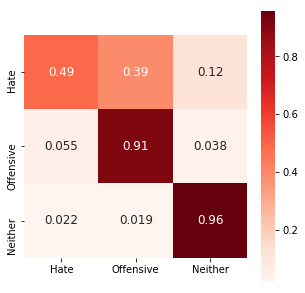

In [49]:
from sklearn.metrics import confusion_matrix

confusion_matrix = confusion_matrix(y_test, y_preds)
matrix_proportions = np.zeros((3, 3))
for i in range(0, 3):
    matrix_proportions[i, :] = confusion_matrix[i, :] / \
        float(confusion_matrix[i, :].sum())
names = ['Hate', 'Offensive', 'Neither']
confusion_df = pd.DataFrame(matrix_proportions, index=names, columns=names)
plt.figure(figsize=(5, 5))
seaborn.heatmap(confusion_df, annot=True, annot_kws={"size": 12}, square=True, cmap="Reds")